# 0.引入所有需要的库和数据集
- 包含word2vec模型、pandas、numpy和gensim
- 其中Gensim是一款开源的第三方Python工具包，用于从原始的非结构化的文本中，无监督地学习到文本隐层的主题向量表达。它支持包括TF-IDF，LSA，LDA，和word2vec在内的多种主题模型算法

In [1]:
from gensim.models import Word2Vec
import pandas as pd
import numpy as np
import gensim

train_data = 'C:\\Users\\jojo\\Documents\\大三上\\专必\\智能信息系统\\实验7\\code\\data\\ctb5.1-pos\\train.tsv'
test_data = 'C:\\Users\\jojo\\Documents\\大三上\\专必\\智能信息系统\\实验7\\code\\data\\ctb5.1-pos\\test.tsv'

# 1.数据读取
---
> 首先构建一个读取数据集的函数
- 以Tab为分隔符进行分隔
- ***skip_blank_lines=False*** 表示读入空行，若设置为True则会跳过空行

In [2]:
def get_data(file_path):
    data = pd.read_csv(file_path, sep='\t', skip_blank_lines=False, header=None)
    # 取出文本部分
    content = data[0]
    # 取出标签部分
    label = data[1]
    
    return content, label

In [3]:
# 读取数据集
X_train, y_train = get_data(train_data)
X_test, y_test = get_data(test_data)

print(X_train[:3])
print(y_test[4:7])

0    上海
1    浦东
2    开发
Name: 0, dtype: object
4    VV
5    JJ
6    NN
Name: 1, dtype: object


# 2. 数据预处理与格式转化
### （1）构建标签字典
> 标签种类总数为36种，共有52w多个标签

- *list(set())*的功能是:对原列表去重并按从小到大排序。
- labels中存放的是所有的样本，而去重后的labels_type中存放的是词性的所有种类

In [4]:
labels = y_train.tolist() + y_test.tolist()
labels_types = list(set(labels))

print(labels_types[:10])
print(labels[:10])
print(len(labels))
print(len(labels_types))

[nan, 'NR', 'VV', 'AD', 'MSP', 'ETC', 'OD', 'LB', 'NT', 'X']
['NR', 'NR', 'NN', 'CC', 'NN', 'NN', 'VV', nan, 'NN', 'NR']
520125
36


In [5]:
labels_dict = {}
labels_index = {"padded_label" : 0}

for index in range(len(labels_types)):
    label = labels_types[index]
    labels_dict.update({label: labels.count(label)})
    labels_index.update({label: index+1})

np.save('y_labels_index.npy', labels_index)     
print("the count of total labels is : "+ str(len(labels)) + "\nthe number of types of labels is : " + str(len(labels_dict)))

the count of total labels is : 520125
the number of types of labels is : 36


- 输出字典（键：类别；值：出现次数）

In [6]:
def print_inventory(dct):
    print("Items held")
    for item, amount in dct.items():
        print("{:<4}:{}".format(item, amount))

print("Here are the specific types and correspond counts: ")
print_inventory(labels_dict)

Here are the specific types and correspond counts: 
Items held
nan :18426
NR  :30570
VV  :69858
AD  :36430
MSP :1336
ETC :1303
OD  :1675
LB  :245
NT  :9659
X   :6
DER :258
PN  :6644
M   :13790
VA  :7755
AS  :4118
JJ  :13234
CS  :892
VE  :3005
VP  :1
CD  :16182
IJ  :12
DT  :5986
SP  :468
PU  :76753
VC  :5404
DEG :12337
CC  :7355
BA  :755
P   :17606
NN  :136643
SB  :455
LC  :7782
NP  :5
DEV :634
DEC :12510
FW  :33


### （2）切分句子
- 因为要考虑词与词之间的关系，因此要把文本切分成句子

> 在文档中的每个句子之间以空格进行分隔，因此可以根据分辨出的空行来分隔每句话

In [7]:
# 按句对X、y进行拆分
def split_corpus_by_sentence(content):
    cleaned_sentence = []
    split_label = content.isnull()
    last_split_index = 0
    index = 0
    while index < len(content):
        current_word = content[index]
        if split_label[index] == True and len(cleaned_sentence) == 0:
            cleaned_sentence.append(np.array(content[last_split_index:index]))
            last_split_index = index + 1
            index += 1
        elif split_label[index] == True  and len(cleaned_sentence) > 0:
            cleaned_sentence.append(np.array(content[last_split_index:index]))
            last_split_index = index + 1
            index += 1
        else:
            index += 1
    return cleaned_sentence

X_train_sent_split = split_corpus_by_sentence(X_train)
y_train_sent_split = split_corpus_by_sentence(y_train)
X_test_sent_split = split_corpus_by_sentence(X_test)
y_test_sent_split = split_corpus_by_sentence(y_test)

print('以句子进行拆分后的句子为：\n', X_train_sent_split[:2])
print('以句子进行拆分后的句子所对应的词性为：\n', y_train_sent_split[:2])

以句子进行拆分后的句子为：
 [array(['上海', '浦东', '开发', '与', '法制', '建设', '同步'], dtype=object), array(['新华社', '上海', '二月', '十日', '电', '（', '记者', '谢金虎', '、', '张持坚', '）'],
      dtype=object)]
以句子进行拆分后的句子所对应的词性为：
 [array(['NR', 'NR', 'NN', 'CC', 'NN', 'NN', 'VV'], dtype=object), array(['NN', 'NR', 'NT', 'NT', 'NN', 'PU', 'NN', 'NR', 'PU', 'NR', 'PU'],
      dtype=object)]


- 进行数据集的拆分，并给出一些句子的词性标注的demo

- 可以看到类别由前面的string值按照排序后的index值转变成了数字表示

In [8]:
def transfer_label_category_index(origin_labels, labels_types):
    transfered_label = []
    for sentence_labels in origin_labels:
        labels_format_index = [labels_types.index(label) for label in sentence_labels]  # 将标签依据字典转化为序号
        transfered_label.append(labels_format_index)
    return transfered_label

y_train_index = transfer_label_category_index(y_train_sent_split, labels_types)
y_test_index = transfer_label_category_index(y_test_sent_split, labels_types)

print(y_train_index[:5])

[[1, 1, 29, 26, 29, 29, 2], [29, 1, 8, 8, 29, 23, 29, 1, 23, 1, 23], [1, 1, 8, 31, 2, 2, 14, 2, 29, 23, 29, 23, 29, 23, 29, 23, 29, 23, 29, 5, 29, 34, 19, 12, 29, 29, 23, 2, 14, 1, 29, 25, 15, 29, 23], [1, 29, 29, 24, 19, 12, 2, 1, 23, 2, 29, 29, 23, 29, 23, 29, 29, 34, 15, 29, 23, 3, 3, 2, 34, 24, 8, 3, 3, 2, 14, 34, 15, 29, 23, 15, 29, 23], [28, 11, 23, 1, 3, 24, 13, 33, 2, 23, 2, 19, 12, 29, 23, 28, 2, 14, 29, 31, 3, 2, 29, 29, 23, 34, 29, 23, 26, 24, 2, 15, 29, 26, 1, 5, 29, 25, 29, 29, 23, 2, 29, 15, 29, 29, 23, 3, 23, 3, 33, 2, 26, 2, 29, 29, 23, 2, 21, 29, 29, 3, 2, 3, 30, 2, 29, 29, 23]]


---
### （3）设置定长向量
- 循环神经网络中处理的是定长向量的问题，因此要限定句子的长度
- 本次实验中设置每句长度为100个词，不满100个词的句子剩余部分全填充为0，因此在此处可以把y标签填充到100个词（不满100的话全部填充为0），保证传入的是一个定长向量因此可以进行矩阵计算
---
### （4）构建张量
- np.zeros()：构建全0的张量
> ***三个维度的张量：***
1. 标签的样本数（句子数）
2. 句子的长度（本例中设定的是100）
3. 标签的类别数（36个种类）

> 因此在此处转换成的是三维数组，最低维的代表词性的种类，每个元素是一个词，用这个办法可以把所有y_label转成三维数组表示。
第二个维度表示一个句子中包含的词，第三个维度代表所有句子

> 在此增加了一个标签种类，总的类数增加到37，加的是一个特殊的类，用来表示长度超出100后被略掉的词

---
- 填充张量：判断对应的词性并把相应的位置由0替换成1

In [9]:
MAX_SEQUENCE_LENGTH = 100  #设置每句长度为100个词，不满的全填充为0

# 标签格式转化
# 构建对应（标签样本数，句子长度，标签类别数（37类）形状的张量，值全为0
y_train_index_padded = np.zeros((len(y_train_index), MAX_SEQUENCE_LENGTH, len(labels_types)+1), dtype='float', order='C')
y_test_index_padded = np.zeros((len(y_test_index), MAX_SEQUENCE_LENGTH, len(labels_types)+1), dtype='float', order='C')

# 填充张量
for sentence_labels_index in range(len(y_train_index)):
    for label_index in range(len(y_train_index[sentence_labels_index])):
        if label_index < MAX_SEQUENCE_LENGTH:
            y_train_index_padded[sentence_labels_index, label_index, y_train_index[sentence_labels_index][label_index]+1] = 1
            
    if len(y_train_index[sentence_labels_index]) < MAX_SEQUENCE_LENGTH:
        for label_index in range(len(y_train_index[sentence_labels_index]), MAX_SEQUENCE_LENGTH):
            y_train_index_padded[sentence_labels_index, label_index, 0] = 1

for sentence_labels_index in range(len(y_test_index)):
    for label_index in range(len(y_test_index[sentence_labels_index])):
        if label_index < MAX_SEQUENCE_LENGTH:
            y_test_index_padded[sentence_labels_index, label_index, y_test_index[sentence_labels_index][label_index]+1] = 1
            
    if len(y_test_index[sentence_labels_index]) < MAX_SEQUENCE_LENGTH:
        for label_index in range(len(y_test_index[sentence_labels_index]), MAX_SEQUENCE_LENGTH):
            y_test_index_padded[sentence_labels_index, label_index, 0] = 1

print(y_train_index_padded[:1])

[[[0. 0. 1. ... 0. 0. 0.]
  [0. 0. 1. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [1. 0. 0. ... 0. 0. 0.]
  [1. 0. 0. ... 0. 0. 0.]
  [1. 0. 0. ... 0. 0. 0.]]]


# 3、word2vec模型导入
### 目的：进入对x的处理

> 导入word2vec的原因：word2vec本身具有词典，与语料库的词典进行对应为后续实验做简化

- 预训练的word2vec模型采用前人用中文维基百科训练好的模型

[word2vec模型链接](https://github.com/Embedding/Chinese-Word-Vectors)

- 模型以二进制存储，因此要用特殊的形式读入（load方式）

In [10]:
## 1 导入 预训练的词向量
myPath = 'C:\\Users\\jojo\\Desktop\\sgns.wiki.word' # 本地词向量的地址
Word2VecModel = gensim.models.KeyedVectors.load_word2vec_format(myPath).wv # 读取词向量，以二进制读取

vector = Word2VecModel.wv['空间']  # 词语的向量，是numpy格式

C:\Users\jojo\anaconda3\envs\your_env_name\lib\site-packages\ipykernel\__main__.py:3: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  app.launch_new_instance()
C:\Users\jojo\anaconda3\envs\your_env_name\lib\site-packages\ipykernel\__main__.py:5: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).


In [11]:
print(type(Word2VecModel.wv)) # 结果为：Word2VecKeyedVectors

for i,j in Word2VecModel.wv.vocab.items():
    print(i) # 此时 i 代表每个单词
    print(j) # j 代表封装了 词频 等信息的 gensim“Vocab”对象，例子：Vocab(count:1481, index:38, sample_int:3701260191)
    break

<class 'gensim.models.keyedvectors.Word2VecKeyedVectors'>
，
Vocab(count:352217, index:0)


C:\Users\jojo\anaconda3\envs\your_env_name\lib\site-packages\ipykernel\__main__.py:1: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  if __name__ == '__main__':
C:\Users\jojo\anaconda3\envs\your_env_name\lib\site-packages\ipykernel\__main__.py:3: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  app.launch_new_instance()


In [12]:
## 2 构造包含所有词语的 list，以及初始化 “词语-序号”字典 和 “词向量”矩阵
vocab_list = [word for word, Vocab in Word2VecModel.wv.vocab.items()]# 存储 所有的 词语

word_index = {" ": 0}# 初始化 `[word : token]` ，后期 tokenize 语料库就是用该词典。
word_vector = {} # 初始化`[word : vector]`字典

# 初始化存储所有向量的大矩阵，留意其中多一位（首行），词向量全为 0，用于 padding补零。
# 行数 为 所有单词数+1 比如 10000+1 ； 列数为 词向量“维度”比如100。
embeddings_matrix = np.zeros((len(vocab_list) + 1, Word2VecModel.vector_size))

C:\Users\jojo\anaconda3\envs\your_env_name\lib\site-packages\ipykernel\__main__.py:2: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  from ipykernel import kernelapp as app


In [13]:
## 3 填充 上述 的字典 和 大矩阵
for i in range(len(vocab_list)):
    # print(i)
    word = vocab_list[i]  # 每个词语
    word_index[word] = i + 1 # 词语：序号
    word_vector[word] = Word2VecModel.wv[word] # 词语：词向量
    embeddings_matrix[i + 1] = Word2VecModel.wv[word]  # 词向量矩阵
    
np.save('x_word_index.npy', word_index)

C:\Users\jojo\anaconda3\envs\your_env_name\lib\site-packages\ipykernel\__main__.py:6: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
C:\Users\jojo\anaconda3\envs\your_env_name\lib\site-packages\ipykernel\__main__.py:7: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).


> 之后需要对语料库数据进行转换：
- 1、文本转化成序号（利用word_index），替换过后的x的表示可以通过序号可以找到对应的向量

In [14]:
from keras.preprocessing import sequence
# 序号化 文本，tokenizer句子，并返回每个句子所对应的词语索引

# 由于将词语转化为索引的word_index需要与词向量模型对齐，故在导入词向量模型后再将X进行处理
def tokenizer(texts, word_index):
    data = []
    for sentence in texts:
        new_sentence = []
        for word in sentence:
            try:
                new_sentence.append(word_index[word])  # 把文本中的 词语转化为index
            except:
                new_sentence.append(0)
            
        data.append(new_sentence)
    # 使用kears的内置函数padding对齐句子,好处是输出numpy数组，不用自己转化了
    data = sequence.pad_sequences(data, maxlen = MAX_SEQUENCE_LENGTH, padding='post', truncating='post')
    
    return data

X_train_tokenized = tokenizer(X_train_sent_split, word_index)
X_test_tokenized = tokenizer(X_test_sent_split, word_index)

print(X_train_tokenized[:1])

Using TensorFlow backend.
C:\Users\jojo\anaconda3\envs\your_env_name\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\jojo\anaconda3\envs\your_env_name\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\jojo\anaconda3\envs\your_env_name\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\jojo\anaconda3\en

[[  347 16980   507    10 15537   603  4380     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0]]


# 4、标引网络构建及训练评估

- 构建模型采用Sequential model
- 序贯模型优势（sequential）：简单易操作，不需要对神经元进行复杂的定义及架构网络。能够通过序贯模型API中定义好的网络层线性进行堆叠构建模型。
- 引入编码层，全连接层，LSTM和dropout

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader，TensorDataset
from torch.autograd import Variable
import numpy as np

class DealDataset(Dataset):
    """
        下载数据、初始化数据，都可以在这里完成
    """
    def __init__(self):
        xy = np.loadtxt('../dataSet/diabetes.csv.gz', delimiter=',', dtype=np.float32) # 使用numpy读取数据
        self.x_data = torch.from_numpy(X_train_tokenized)
        self.y_data = torch.from_numpy(y_train_index_padded)
        self.len = xy.shape[0]
    
    def __getitem__(self, index):
        return self.x_data[index], self.y_data[index]

    def __len__(self):
        return self.len

# 实例化这个类，然后我们就得到了Dataset类型的数据，记下来就将这个类传给DataLoader，就可以了。    
dealDataset = DealDataset()

train_loader2 = DataLoader(dataset=dealDataset,
                          batch_size=32,
                          shuffle=True)


for epoch in range(2):
    for i, data in enumerate(train_loader2):
        # 将数据从 train_loader 中读出来,一次读取的样本数是32个
        inputs, labels = data

        # 将这些数据转换成Variable类型
        inputs, labels = Variable(inputs), Variable(labels)

        # 接下来就是跑模型的环节了，我们这里使用print来代替
        print("epoch：", epoch, "的第" , i, "个inputs", inputs.data.size(), "labels", labels.data.size())

In [16]:
import torch.nn as nn
import torch
import torch.nn.functional as F

class TextRNN(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_size, num_of_class, weights=None, rnn_type="RNN"):
        super(TextRNN, self).__init__()

        self.vocab_size = vocab_size
        self.hidden_size = hidden_size
        self.num_of_class = num_of_class
        self.embedding_dim = embedding_dim
        self.rnn_type = rnn_type

        if weights is not None:
            self.embed = nn.Embedding(num_embeddings=vocab_size, embedding_dim=embedding_dim, _weight=weights)
        else:
            self.embed = nn.Embedding(num_embeddings=vocab_size, embedding_dim=embedding_dim)

        if rnn_type == "RNN":
            self.rnn = nn.RNN(input_size=embedding_dim, hidden_size=hidden_size, batch_first=True)
            self.hidden2label = nn.Linear(hidden_size, num_of_class)
        elif rnn_type == "LSTM":
            self.lstm = nn.LSTM(input_size=embedding_dim, hidden_size=hidden_size, batch_first=True, bidirectional=True)
            self.hidden2label = nn.Linear(hidden_size*2, num_of_class)

    def forward(self, input_sents):
        # input_sents (batch_size, seq_len)
        batch_size, seq_len = input_sents.shape
        # (batch_size, seq_len, embedding_dim)
        embed_out = self.embed(input_sents)

        if self.rnn_type == "RNN":
            h0 = torch.randn(1, batch_size, self.hidden_size)
            _, hn = self.rnn(embed_out, h0)
        elif self.rnn_type == "LSTM":
            h0, c0 = torch.randn(2, batch_size, self.hidden_size), torch.randn(2, batch_size, self.hidden_size)
            output, (hn, _) = self.lstm(embed_out, (h0, c0))

        logits = self.hidden2label(hn).squeeze(0)

        return logits

In [17]:
#main
import torch
import torchvision
from torch import nn
from torch.autograd import Variable
import torchvision.datasets as dsets
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

model_names = ["LSTM", "RNN"] 
 
#define hyperparameter
EPOCH = 1
BATCH_SIZE = 64
TIME_STEP = 28    #time_step / image_height
INPUT_SIZE = 28    #input_step / image_width
LR = 0.01
DOWNLOAD = True


In [19]:
train_data = dsets.MNIST(root='./', train=True, transform=torchvision.transforms.ToTensor(), download=True)
test_data = dsets.MNIST(root='./', train=False, transform=torchvision.transforms.ToTensor())
test_x = test_data.test_data.type(torch.FloatTensor)[:2000]/255
test_y = test_data.test_labels.numpy()[:2000]

100.1%

Extracting ./MNIST\raw\train-images-idx3-ubyte.gz to ./MNIST\raw


113.5%

Extracting ./MNIST\raw\train-labels-idx1-ubyte.gz to ./MNIST\raw


100.4%

Extracting ./MNIST\raw\t10k-images-idx3-ubyte.gz to ./MNIST\raw


180.4%..\torch\csrc\utils\tensor_numpy.cpp:141: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


Extracting ./MNIST\raw\t10k-labels-idx1-ubyte.gz to ./MNIST\raw
Processing...
Done!


C:\Users\jojo\anaconda3\envs\your_env_name\lib\site-packages\torchvision\datasets\mnist.py:60: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")
C:\Users\jojo\anaconda3\envs\your_env_name\lib\site-packages\torchvision\datasets\mnist.py:50: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")


In [35]:
#use dataloader to batch input dateset
train_loader = torch.utils.data.DataLoader(dataset=train_data, batch_size=BATCH_SIZE, shuffle=True)

In [36]:
#print(test_x[:3])
print(train_loader)

In [37]:
#define the RNN class
class RNN(nn.Module):
    #overload __init__() method
    def __init__(self):
        super(RNN, self).__init__()
        
        self.rnn = nn.LSTM(
            input_size=28,
            hidden_size=64,
            num_layers=1,
            batch_first=True,
        )
        self.out = nn.Linear(64,10)
        
    #overload forward() method
    def forward(self, x):
        r_out, (h_n, h_c) = self.rnn(x, None)
        out = self.out(r_out[: ,-1, :])
        return out
rnn = RNN()
print(rnn)

RNN(
  (rnn): LSTM(28, 64, batch_first=True)
  (out): Linear(in_features=64, out_features=10, bias=True)
)


In [38]:
#define optimizer with Adam optim
optimizer = torch.optim.Adam(rnn.parameters(), lr=LR)
#define cross entropy loss function
loss_func = nn.CrossEntropyLoss()

In [39]:
#training and testing
for epoch in range(EPOCH):
    for step, (b_x, b_y) in enumerate(train_loader):
        #recover x as (batch, time_step, input_size)
        b_x = b_x.view(-1, 28, 28)
        
        output = rnn(b_x)
        loss = loss_func(output, b_y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if step % 50 == 0:
            #train with rnn
            test_output = rnn(test_x)
            #loss function
            pred_y = torch.max(test_output, 1)[1].data.numpy()
            #accuracy calculate
            acc = float((pred_y == test_y).astype(int).sum()) / float(test_y.size)
            print('Epoch: ', (epoch), 'train loss: %.3f'%loss.data.numpy(), 'test acc: %.3f'%(acc))

Epoch:  0 train loss: 2.295 test acc: 0.089
Epoch:  0 train loss: 1.271 test acc: 0.527
Epoch:  0 train loss: 0.675 test acc: 0.679
Epoch:  0 train loss: 0.519 test acc: 0.808
Epoch:  0 train loss: 0.436 test acc: 0.859
Epoch:  0 train loss: 0.374 test acc: 0.897
Epoch:  0 train loss: 0.279 test acc: 0.896
Epoch:  0 train loss: 0.197 test acc: 0.883
Epoch:  0 train loss: 0.270 test acc: 0.926
Epoch:  0 train loss: 0.306 test acc: 0.922
Epoch:  0 train loss: 0.268 test acc: 0.936
Epoch:  0 train loss: 0.227 test acc: 0.944
Epoch:  0 train loss: 0.165 test acc: 0.943
Epoch:  0 train loss: 0.200 test acc: 0.952
Epoch:  0 train loss: 0.068 test acc: 0.946
Epoch:  0 train loss: 0.055 test acc: 0.959
Epoch:  0 train loss: 0.364 test acc: 0.953
Epoch:  0 train loss: 0.229 test acc: 0.940
Epoch:  0 train loss: 0.218 test acc: 0.957


In [23]:
# print 100 predictions from test data
numTest = 100
test_output = rnn(test_x[:numTest].view(-1, 28, 28))
pred_y = torch.max(test_output, 1)[1].data.numpy()
print(pred_y, 'prediction number')
print(test_y[:numTest], 'real number')
ErrorCount = 0.0
for i in pred_y:
	if pred_y[i] != test_y[i]:
		ErrorCount += 1
print('ErrorRate : %.3f'%(ErrorCount / numTest))

[7 2 1 0 4 1 4 9 5 9 0 6 9 0 1 5 9 7 3 4 9 6 6 5 4 0 7 4 0 1 3 1 3 4 7 2 7
 1 2 1 1 7 4 2 3 5 1 2 4 4 6 3 5 5 6 0 4 1 9 5 7 2 9 3 7 4 6 4 3 0 7 0 2 9
 1 7 3 2 9 7 7 6 2 7 8 4 7 3 6 1 3 6 9 3 1 4 1 7 6 9] prediction number
[7 2 1 0 4 1 4 9 5 9 0 6 9 0 1 5 9 7 3 4 9 6 6 5 4 0 7 4 0 1 3 1 3 4 7 2 7
 1 2 1 1 7 4 2 3 5 1 2 4 4 6 3 5 5 6 0 4 1 9 5 7 8 9 3 7 4 6 4 3 0 7 0 2 9
 1 7 3 2 9 7 7 6 2 7 8 4 7 3 6 1 3 6 9 3 1 4 1 7 6 9] real number
ErrorRate : 0.000


In [22]:
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense, Dropout
import keras

EMBEDDING_DIM = 300 #词向量维度

model = Sequential()
model.add(Embedding(input_dim = len(embeddings_matrix), # 字典长度
                    output_dim = EMBEDDING_DIM, # 词向量 长度（300）
                    weights=[embeddings_matrix], # 重点：预训练的词向量系数
                    input_length=MAX_SEQUENCE_LENGTH, # 每句话的 最大长度（必须padding） 
                    trainable=False # 是否在 训练的过程中 更新词向量
                   ))

- 构建模型架构

In [23]:
# input shape (Batch_size, Time_step, Input_Sizes)
model.add(LSTM(128, input_shape=(MAX_SEQUENCE_LENGTH, EMBEDDING_DIM), activation='tanh', return_sequences=True))
model.add(Dropout(0.5))
model.add(Dense(64, input_shape=(MAX_SEQUENCE_LENGTH, 128), activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(len(labels_types)+1, input_shape=(MAX_SEQUENCE_LENGTH, 64), activation='softmax'))
#model.add() #不需要dropout

### 定义优化器和损失函数

In [24]:
from keras import optimizers

adam = optimizers.Adam(lr=0.01, decay=1e-6)
model.compile(loss='categorical_crossentropy',
              optimizer=adam,
              metrics=['accuracy'])

In [25]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 100, 300)          105665400 
_________________________________________________________________
lstm_1 (LSTM)                (None, 100, 128)          219648    
_________________________________________________________________
dropout_1 (Dropout)          (None, 100, 128)          0         
_________________________________________________________________
dense_1 (Dense)              (None, 100, 64)           8256      
_________________________________________________________________
dropout_2 (Dropout)          (None, 100, 64)           0         
_________________________________________________________________
dense_2 (Dense)              (None, 100, 37)           2405      
Total params: 105,895,709
Trainable params: 230,309
Non-trainable params: 105,665,400
__________________________________

In [26]:
print(X_train_tokenized.shape, y_train_index_padded.shape)

(18078, 100) (18078, 100, 37)


In [27]:
network_history = model.fit(X_train_tokenized, y_train_index_padded,
          epochs=20,
          batch_size=128,          
          validation_split=0.05,  ##加入验证集
          verbose=1
         )
print('evaluation!')
score = model.evaluate(X_test_tokenized, y_test_index_padded, batch_size=128)

Train on 17174 samples, validate on 904 samples
Epoch 1/20
17174/17174 [==============================] - 57s 3ms/step - loss: 0.4185 - acc: 0.8870 - val_loss: 0.1680 - val_acc: 0.9464
Epoch 2/20
17174/17174 [==============================] - 65s 4ms/step - loss: 0.1697 - acc: 0.9477 - val_loss: 0.1412 - val_acc: 0.9537
Epoch 3/20
17174/17174 [==============================] - 66s 4ms/step - loss: 0.1432 - acc: 0.9555 - val_loss: 0.1288 - val_acc: 0.9571
Epoch 4/20
17174/17174 [==============================] - 58s 3ms/step - loss: 0.1303 - acc: 0.9592 - val_loss: 0.1235 - val_acc: 0.9591
Epoch 5/20
17174/17174 [==============================] - 59s 3ms/step - loss: 0.1222 - acc: 0.9616 - val_loss: 0.1181 - val_acc: 0.9615
Epoch 6/20
17174/17174 [==============================] - 58s 3ms/step - loss: 0.1164 - acc: 0.9632 - val_loss: 0.1160 - val_acc: 0.9621
Epoch 7/20
17174/17174 [==============================] - 65s 4ms/step - loss: 0.1123 - acc: 0.9646 - val_loss: 0.1138 - val_acc: 

KeyboardInterrupt: 

In [ ]:
print('训练的模型经在测试集上验证获得的loss和accuracy为：')
print(score)

## RNN（循环神经网络）

- 神经网络模型只能单独的取处理一个个的输入，前一个输入和后一个输入是完全没有关系的。
- 但是，某些任务需要能够更好的处理**序列**的信息，即前面的输入和后面的输入是有关系的。

以nlp的一个最简单词性标注任务来说
> “我 吃 苹果”。

很明显，一个句子中，前一个单词其实对于当前单词的词性预测是有很大影响的，比如预测苹果的时候，由于前面的吃是一个动词，那么很显然苹果作为名词的概率就会远大于动词的概率，因为动词后面接名词很常见，而动词后面接动词很少见。

- 于是就引入了循环神经网络

# 5、可视化训练信息

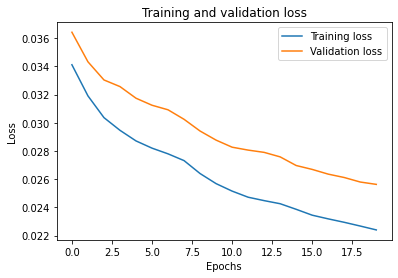

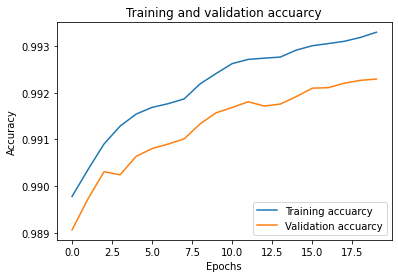

In [21]:
import matplotlib.pyplot as plt
%matplotlib inline

def plot_history(network_history):
    plt.figure()
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.plot(network_history.history['loss'], label='Training loss')
    plt.plot(network_history.history['val_loss'], label='Validation loss')
    plt.legend()
    plt.title('Training and validation loss')
    

    plt.figure()
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.plot(network_history.history['acc'], label='Training accuarcy')
    plt.plot(network_history.history['val_acc'], label='Validation accuarcy')
    plt.legend( loc='lower right')
    plt.title('Training and validation accuarcy')
    plt.show()

plot_history(att2)

# 6、测试与检验

In [25]:
print(model.predict(X_test_tokenized[:1]))

[[[7.86209057e-07 9.76780370e-07 1.20981771e-03 ... 5.69924386e-03
   4.14206646e-02 5.38108907e-07]
  [1.13918541e-10 1.90582355e-10 1.49025675e-06 ... 8.56595725e-05
   3.54829081e-03 4.55332327e-10]
  [8.23291695e-12 4.37434845e-11 2.12401541e-09 ... 4.21064626e-03
   4.37797826e-06 2.11769887e-07]
  ...
  [1.29847663e-07 1.77626006e-07 1.10353678e-04 ... 1.59663300e-03
   2.33148858e-02 4.22922966e-07]
  [1.29847663e-07 1.77626006e-07 1.10353678e-04 ... 1.59663300e-03
   2.33148858e-02 4.22922966e-07]
  [1.29847422e-07 1.77626006e-07 1.10353576e-04 ... 1.59663218e-03
   2.33148746e-02 4.22922170e-07]]]


In [26]:
print(y_test_index_padded[:1])

[[[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]]


# 7、模型的储存与加载

In [32]:
# 模型的存储
pm = "./cixing_model.h5"
model.save(pm)
print("Model saved!")

Model saved!


In [35]:
# 加载存储的模型开始预测
from keras.models import load_model

print("Loading model...")
load_model = load_model("./cixing_model.h5")

# 使用测试集中的第一条开始预测
print("Using loaded model to predict...")
predicted = load_model.predict(X_test_tokenized[:1])

# 呈现预测结果
print("预测结果为：\n", predicted[0][0])

Loading model...
Using loaded model to predict...
预测结果为：
 [4.04630300e-05 1.16919955e-06 7.85740256e-01 1.62828553e-06
 5.10407153e-05 7.18984347e-06 3.44756677e-06 1.25117496e-01
 2.09058067e-04 6.97166570e-06 9.69335204e-04 7.97817734e-07
 3.54493549e-03 1.18479504e-04 1.05112523e-03 2.56112020e-04
 8.77654384e-06 1.40340069e-06 2.59451587e-02 1.45456170e-05
 8.80271837e-05 5.80040137e-07 8.32478472e-05 1.08266051e-03
 7.69139209e-04 1.69123829e-04 7.66462600e-03 1.37587544e-03
 2.79088417e-04 3.96143682e-02 2.69746437e-04 2.65271274e-06
 3.48273921e-09 1.16690656e-03 6.85484395e-07 9.11407128e-08
 4.34363168e-03]


In [33]:
print(y_test_index_padded[0][0])

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
